https://www.kaggle.com/competitions/playground-series-s4e3/data

In [1]:
#%reset

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputClassifier

import optuna
from optuna.multi_objective import study
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

# Reading the file

In [3]:
DATA_URL = "https://raw.githubusercontent.com/enpure/kaggle--Steel-Plate-Defect-Prediction/main/"
train = pd.read_csv(DATA_URL + "train.csv", index_col='id')
test = pd.read_csv(DATA_URL + "test.csv", index_col='id')
submission = pd.read_csv(DATA_URL + "sample_submission.csv", index_col='id')

pd.set_option('display.max_columns', None)
display(train.columns) == display(test.columns)
print('The dimensions of the train dataset is: ', train.shape)
print('The dimensions of the test dataset is: ', test.shape)

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults'],
      dtype='object')

Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas'],
      dtype='object')

The dimensions of the train dataset is:  (19219, 34)
The dimensions of the test dataset is:  (12814, 27)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19219 entries, 0 to 19218
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              19219 non-null  int64  
 1   X_Maximum              19219 non-null  int64  
 2   Y_Minimum              19219 non-null  int64  
 3   Y_Maximum              19219 non-null  int64  
 4   Pixels_Areas           19219 non-null  int64  
 5   X_Perimeter            19219 non-null  int64  
 6   Y_Perimeter            19219 non-null  int64  
 7   Sum_of_Luminosity      19219 non-null  int64  
 8   Minimum_of_Luminosity  19219 non-null  int64  
 9   Maximum_of_Luminosity  19219 non-null  int64  
 10  Length_of_Conveyer     19219 non-null  int64  
 11  TypeOfSteel_A300       19219 non-null  int64  
 12  TypeOfSteel_A400       19219 non-null  int64  
 13  Steel_Plate_Thickness  19219 non-null  int64  
 14  Edges_Index            19219 non-null  float64
 15  Empty_I

In [5]:
train.describe().style.background_gradient(cmap='Blues')

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,709.854675,753.857641,1849756.040012,1846605.345439,1683.987616,95.654665,64.124096,191846.678235,84.808419,128.647380,1459.350747,0.402674,0.596337,76.213122,0.352939,0.409309,0.574520,0.030609,0.614749,0.831652,0.591899,2.473475,1.312667,1.389737,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,531.544189,499.836603,1903553.850679,1896295.137914,3730.319865,177.821382,101.054178,442024.694057,28.800344,14.196976,145.568687,0.490449,0.490644,53.931960,0.318976,0.124143,0.259436,0.047302,0.222391,0.220966,0.482050,0.760575,0.467848,0.405549,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,4.000000,6712.000000,6724.000000,6.000000,2.000000,1.000000,250.000000,0.000000,39.000000,1227.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.105000,0.000000,0.778200,0.301000,0.000000,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,214.000000,657468.000000,657502.000000,89.000000,15.000000,14.000000,9848.000000,70.000000,124.000000,1358.000000,0.000000,0.000000,40.000000,0.058600,0.317500,0.375750,0.006600,0.451600,0.655200,0.000000,1.949400,1.000000,1.079200,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,777.000000,796.000000,1398169.000000,1398179.000000,168.000000,25.000000,23.000000,18238.000000,90.000000,127.000000,1364.000000,0.000000,1.000000,69.000000,0.238500,0.413500,0.545400,0.009500,0.636400,0.964300,1.000000,2.227900,1.146100,1.322200,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1152.000000,1165.000000,2368032.000000,2362511.000000,653.000000,64.000000,61.000000,67978.000000,105.000000,135.000000,1652.000000,1.000000,1.000000,80.000000,0.656100,0.494600,0.818200,0.019100,0.785700,1.000000,1.000000,2.814900,1.431400,1.707600,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,12987661.000000,12987692.000000,152655.000000,7553.000000,903.000000,11591414.000000,196.000000,253.000000,1794.000000,1.000000,1.000000,300.000000,0.995200,0.927500,1.000000,0.665100,1.000000,1.000000,1.000000,4.554300,2.997300,4.033300,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# train[train.duplicated(keep=False)]
train.duplicated().sum()

0

In [7]:
# test[test.duplicated(keep=False)]
test.duplicated().sum()

0

In [8]:
train.drop_duplicates(inplace=True)

In [9]:
train.isna().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

<Axes: ylabel='id'>

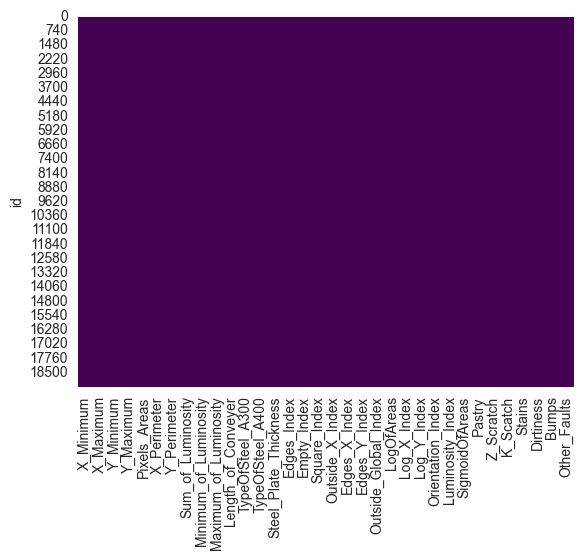

In [10]:
sns.heatmap(train.isnull(),cbar=False,cmap='viridis')

In [11]:
# Inspect useless features
train.nunique().sort_values()

Other_Faults                2
Bumps                       2
TypeOfSteel_A400            2
Pastry                      2
TypeOfSteel_A300            2
K_Scatch                    2
Dirtiness                   2
Stains                      2
Z_Scratch                   2
Outside_Global_Index        4
Steel_Plate_Thickness      27
Maximum_of_Luminosity      98
Length_of_Conveyer         99
Minimum_of_Luminosity     162
Log_X_Index               206
Log_Y_Index               241
Y_Perimeter               331
X_Perimeter               460
SigmoidOfAreas            467
Outside_X_Index           525
Edges_Y_Index             900
LogOfAreas               1072
Edges_X_Index            1102
Square_Index             1118
Pixels_Areas             1154
X_Minimum                1191
X_Maximum                1259
Orientation_Index        1598
Empty_Index              1748
Edges_Index              1849
Luminosity_Index         2046
Sum_of_Luminosity        2595
Y_Maximum                3341
Y_Minimum 

# Exploratory Data Analysis (EDA)

In [12]:
target_cols = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps','Other_Faults']
train_cols = [column for column in train.columns if column not in target_cols + ['id']]
targets = train[target_cols].sum(axis=0).sort_values(ascending=False)
targets

Other_Faults    6558
Bumps           4763
K_Scatch        3432
Pastry          1466
Z_Scratch       1150
Stains           568
Dirtiness        485
dtype: int64

In [13]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train.select_dtypes(include=['object']).columns.tolist()   
num_cols_test = test.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols_test = test.select_dtypes(include=['object']).columns.tolist()   

## Heatmap of the dataset

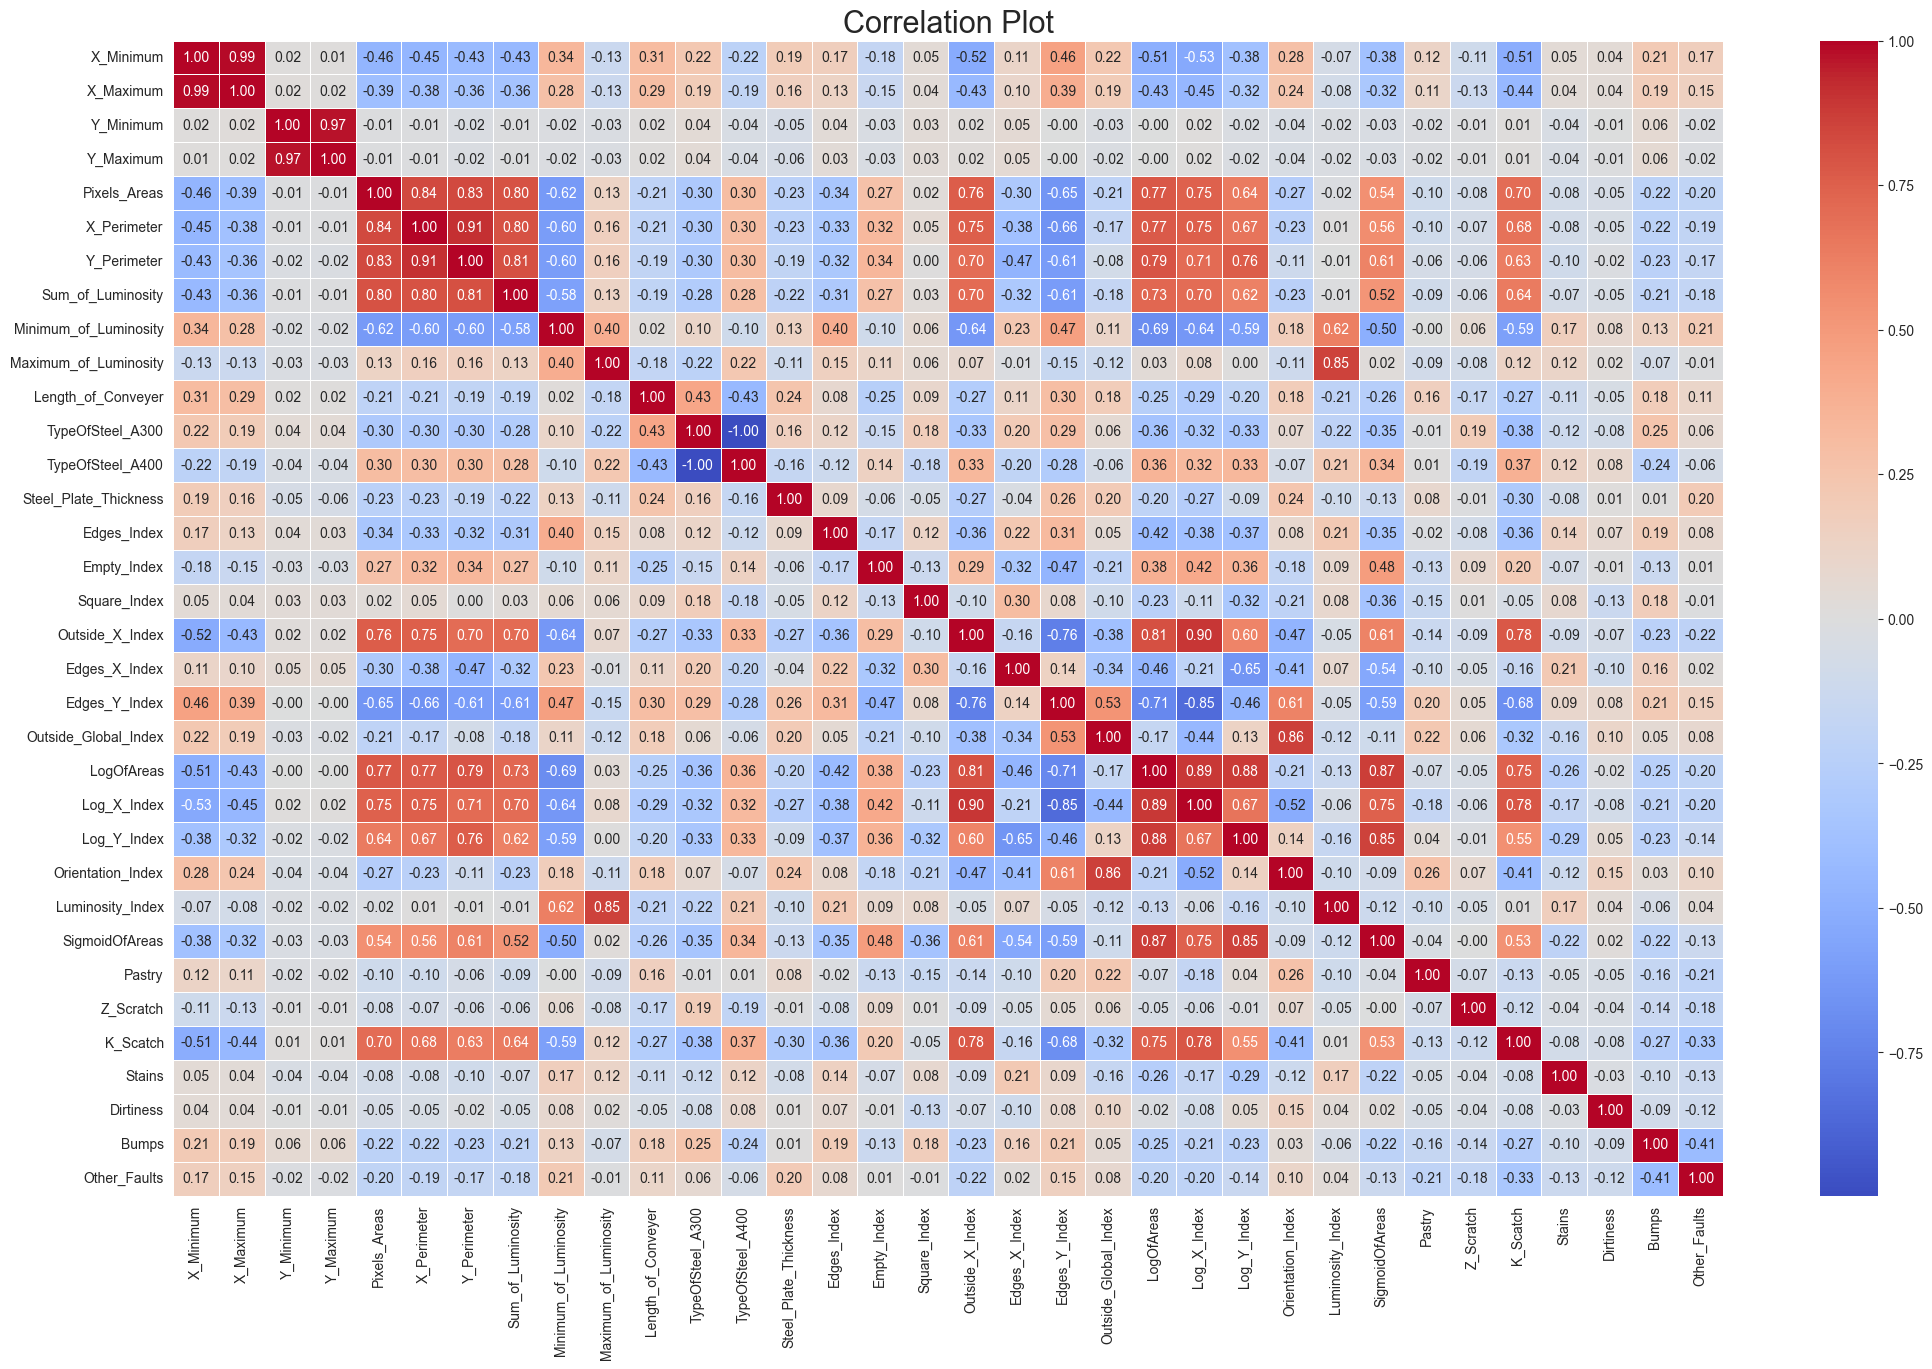

In [14]:
# Compute the correlation matrix
correlation_matrix = train[num_cols].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(25, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Plot', fontsize=22)  
plt.show()

## Data Visualization

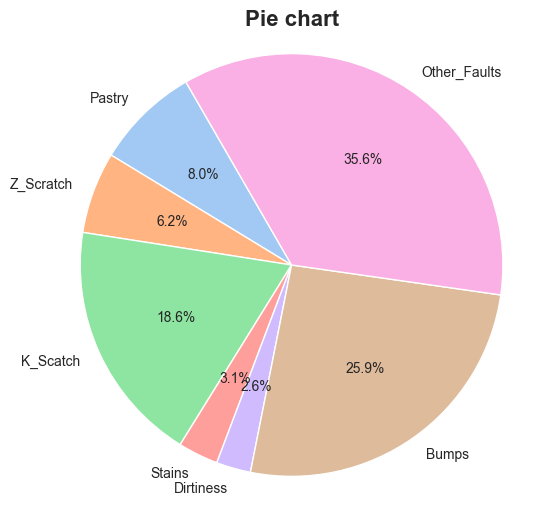

In [15]:
col_sum = train[target_cols].sum()

sns.set_style('whitegrid')
colors = sns.color_palette('pastel')

plt.figure(figsize=(6, 6))
plt.pie(col_sum, labels=col_sum.index, colors=colors, autopct='%1.1f%%', startangle=120)
plt.title('Pie chart', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

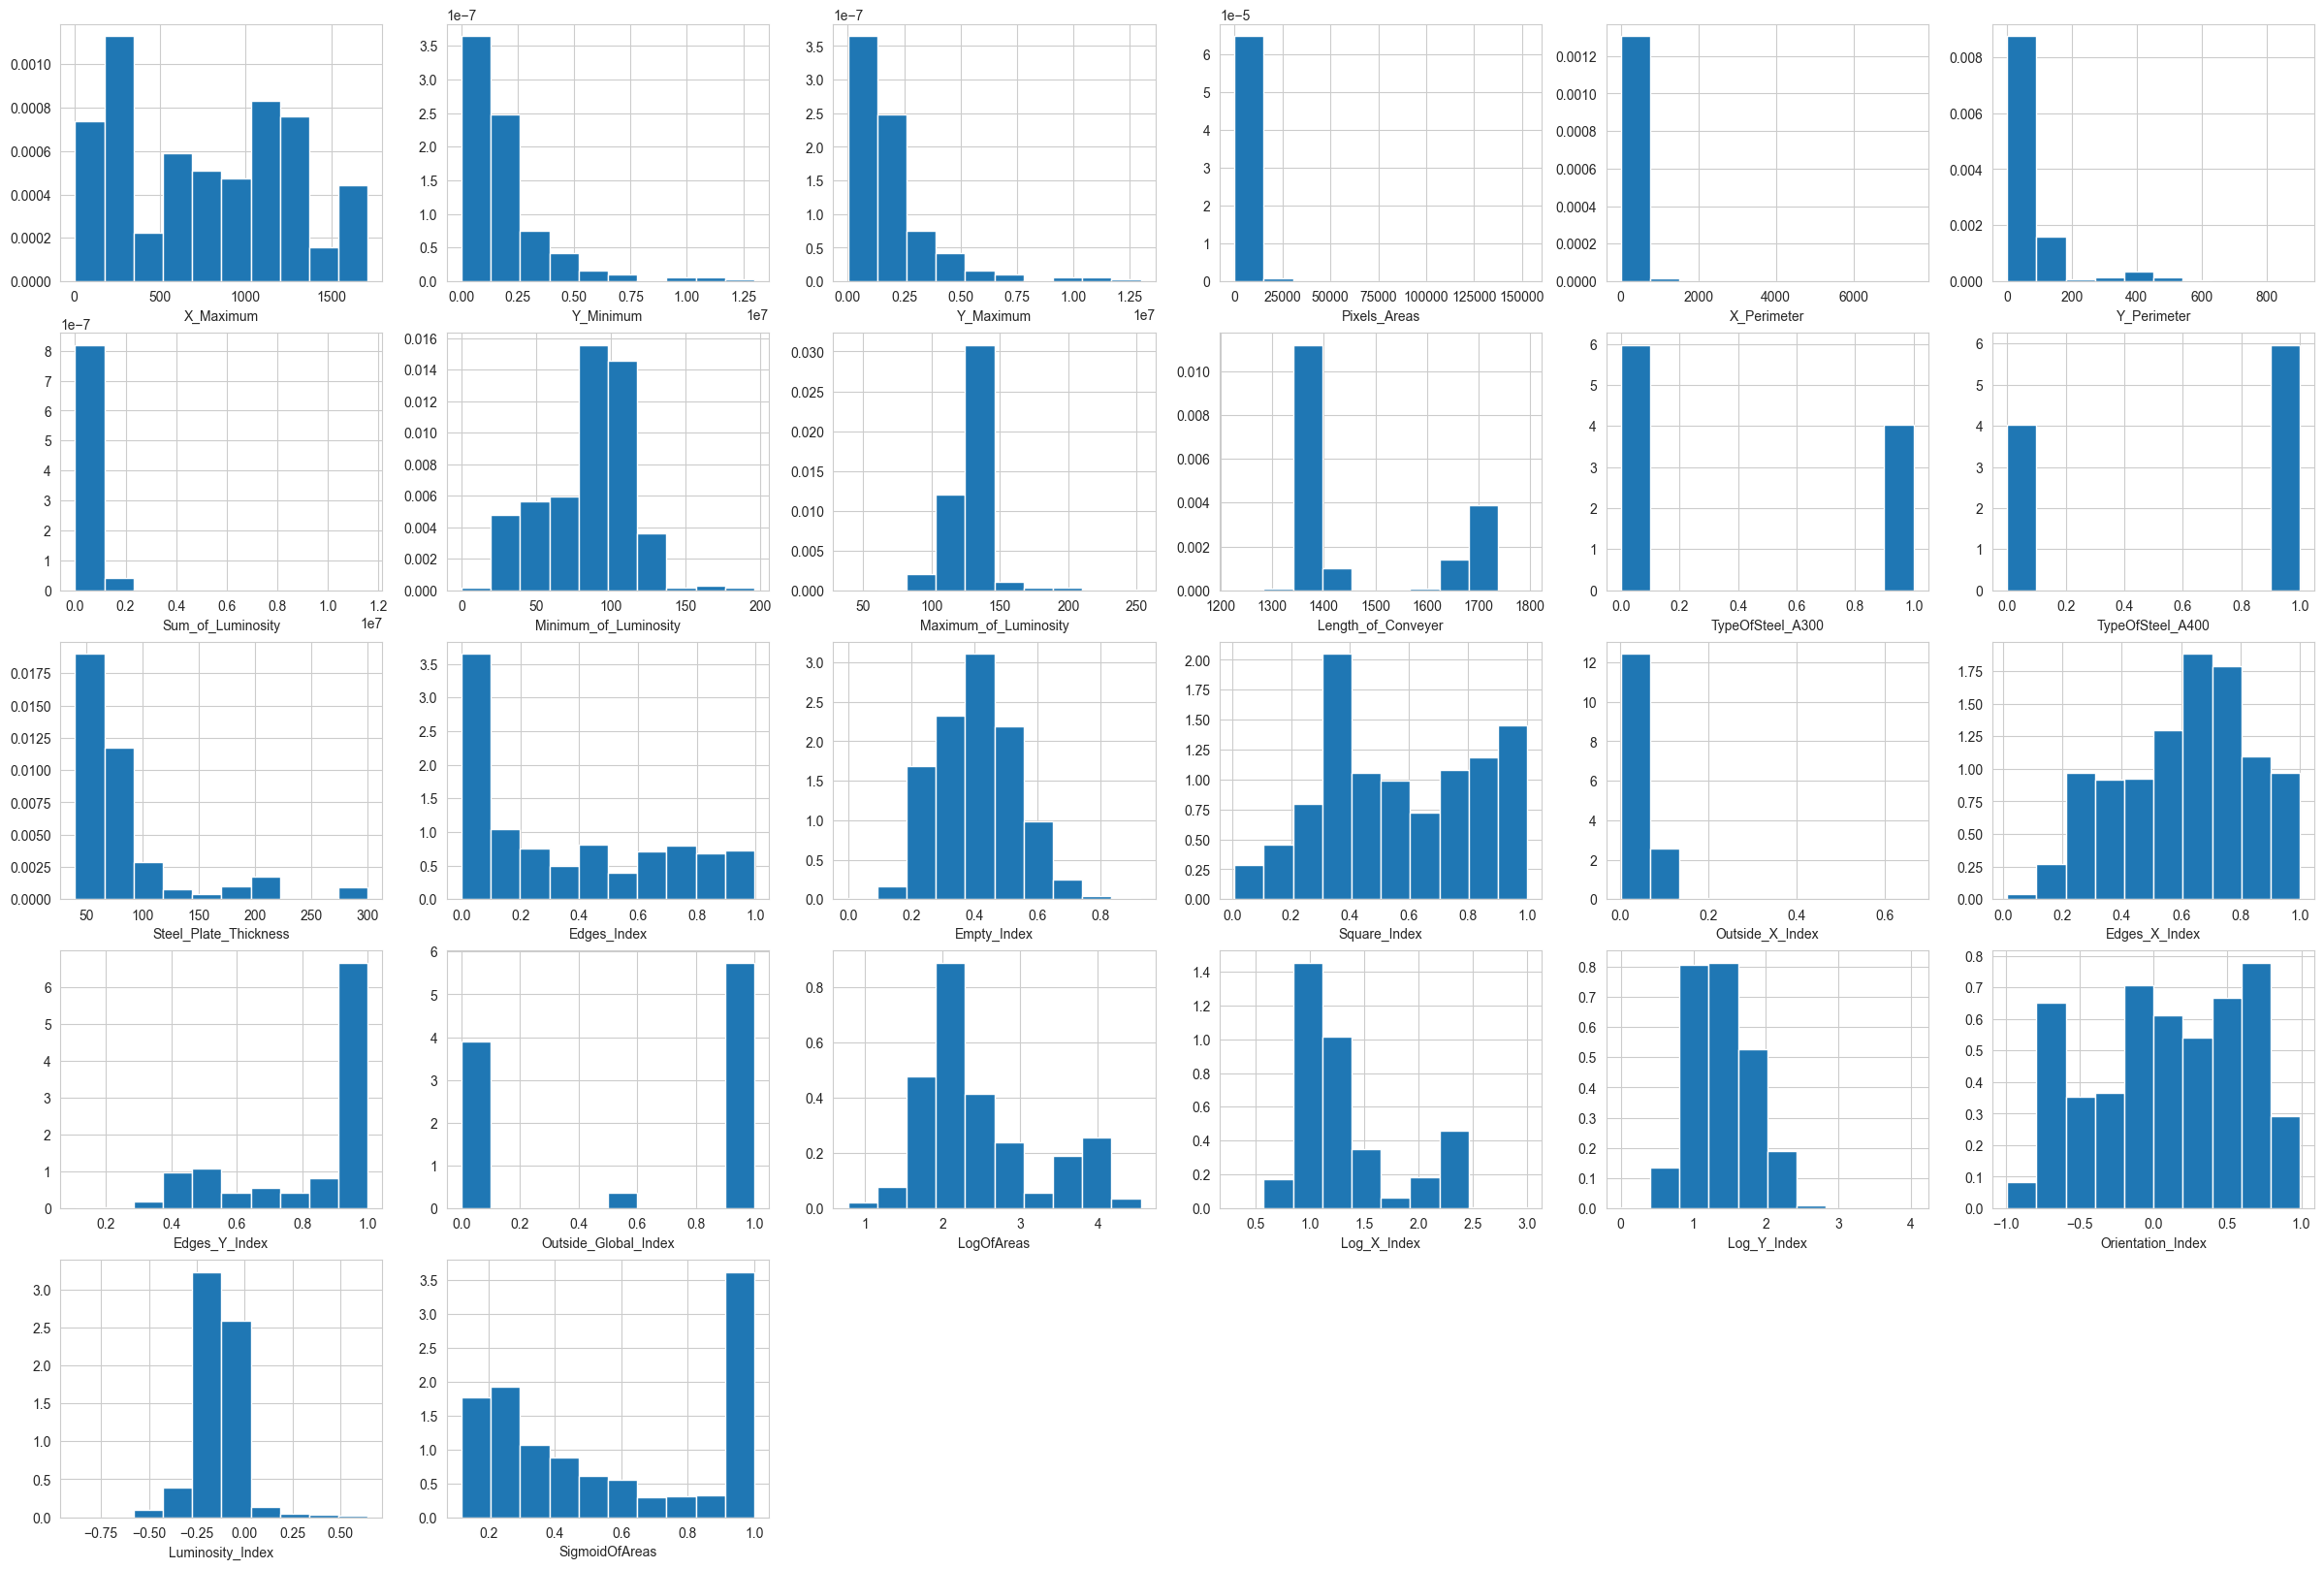

In [16]:
# Train dataset
plt.figure(figsize=(30, 20))

for index, col in enumerate(train.iloc[:, 1:-7].columns, start=1):
    plt.subplot(5, 6, index)
    plt.hist(train[col], density=True)
    plt.xlabel(col)
    
plt.show()

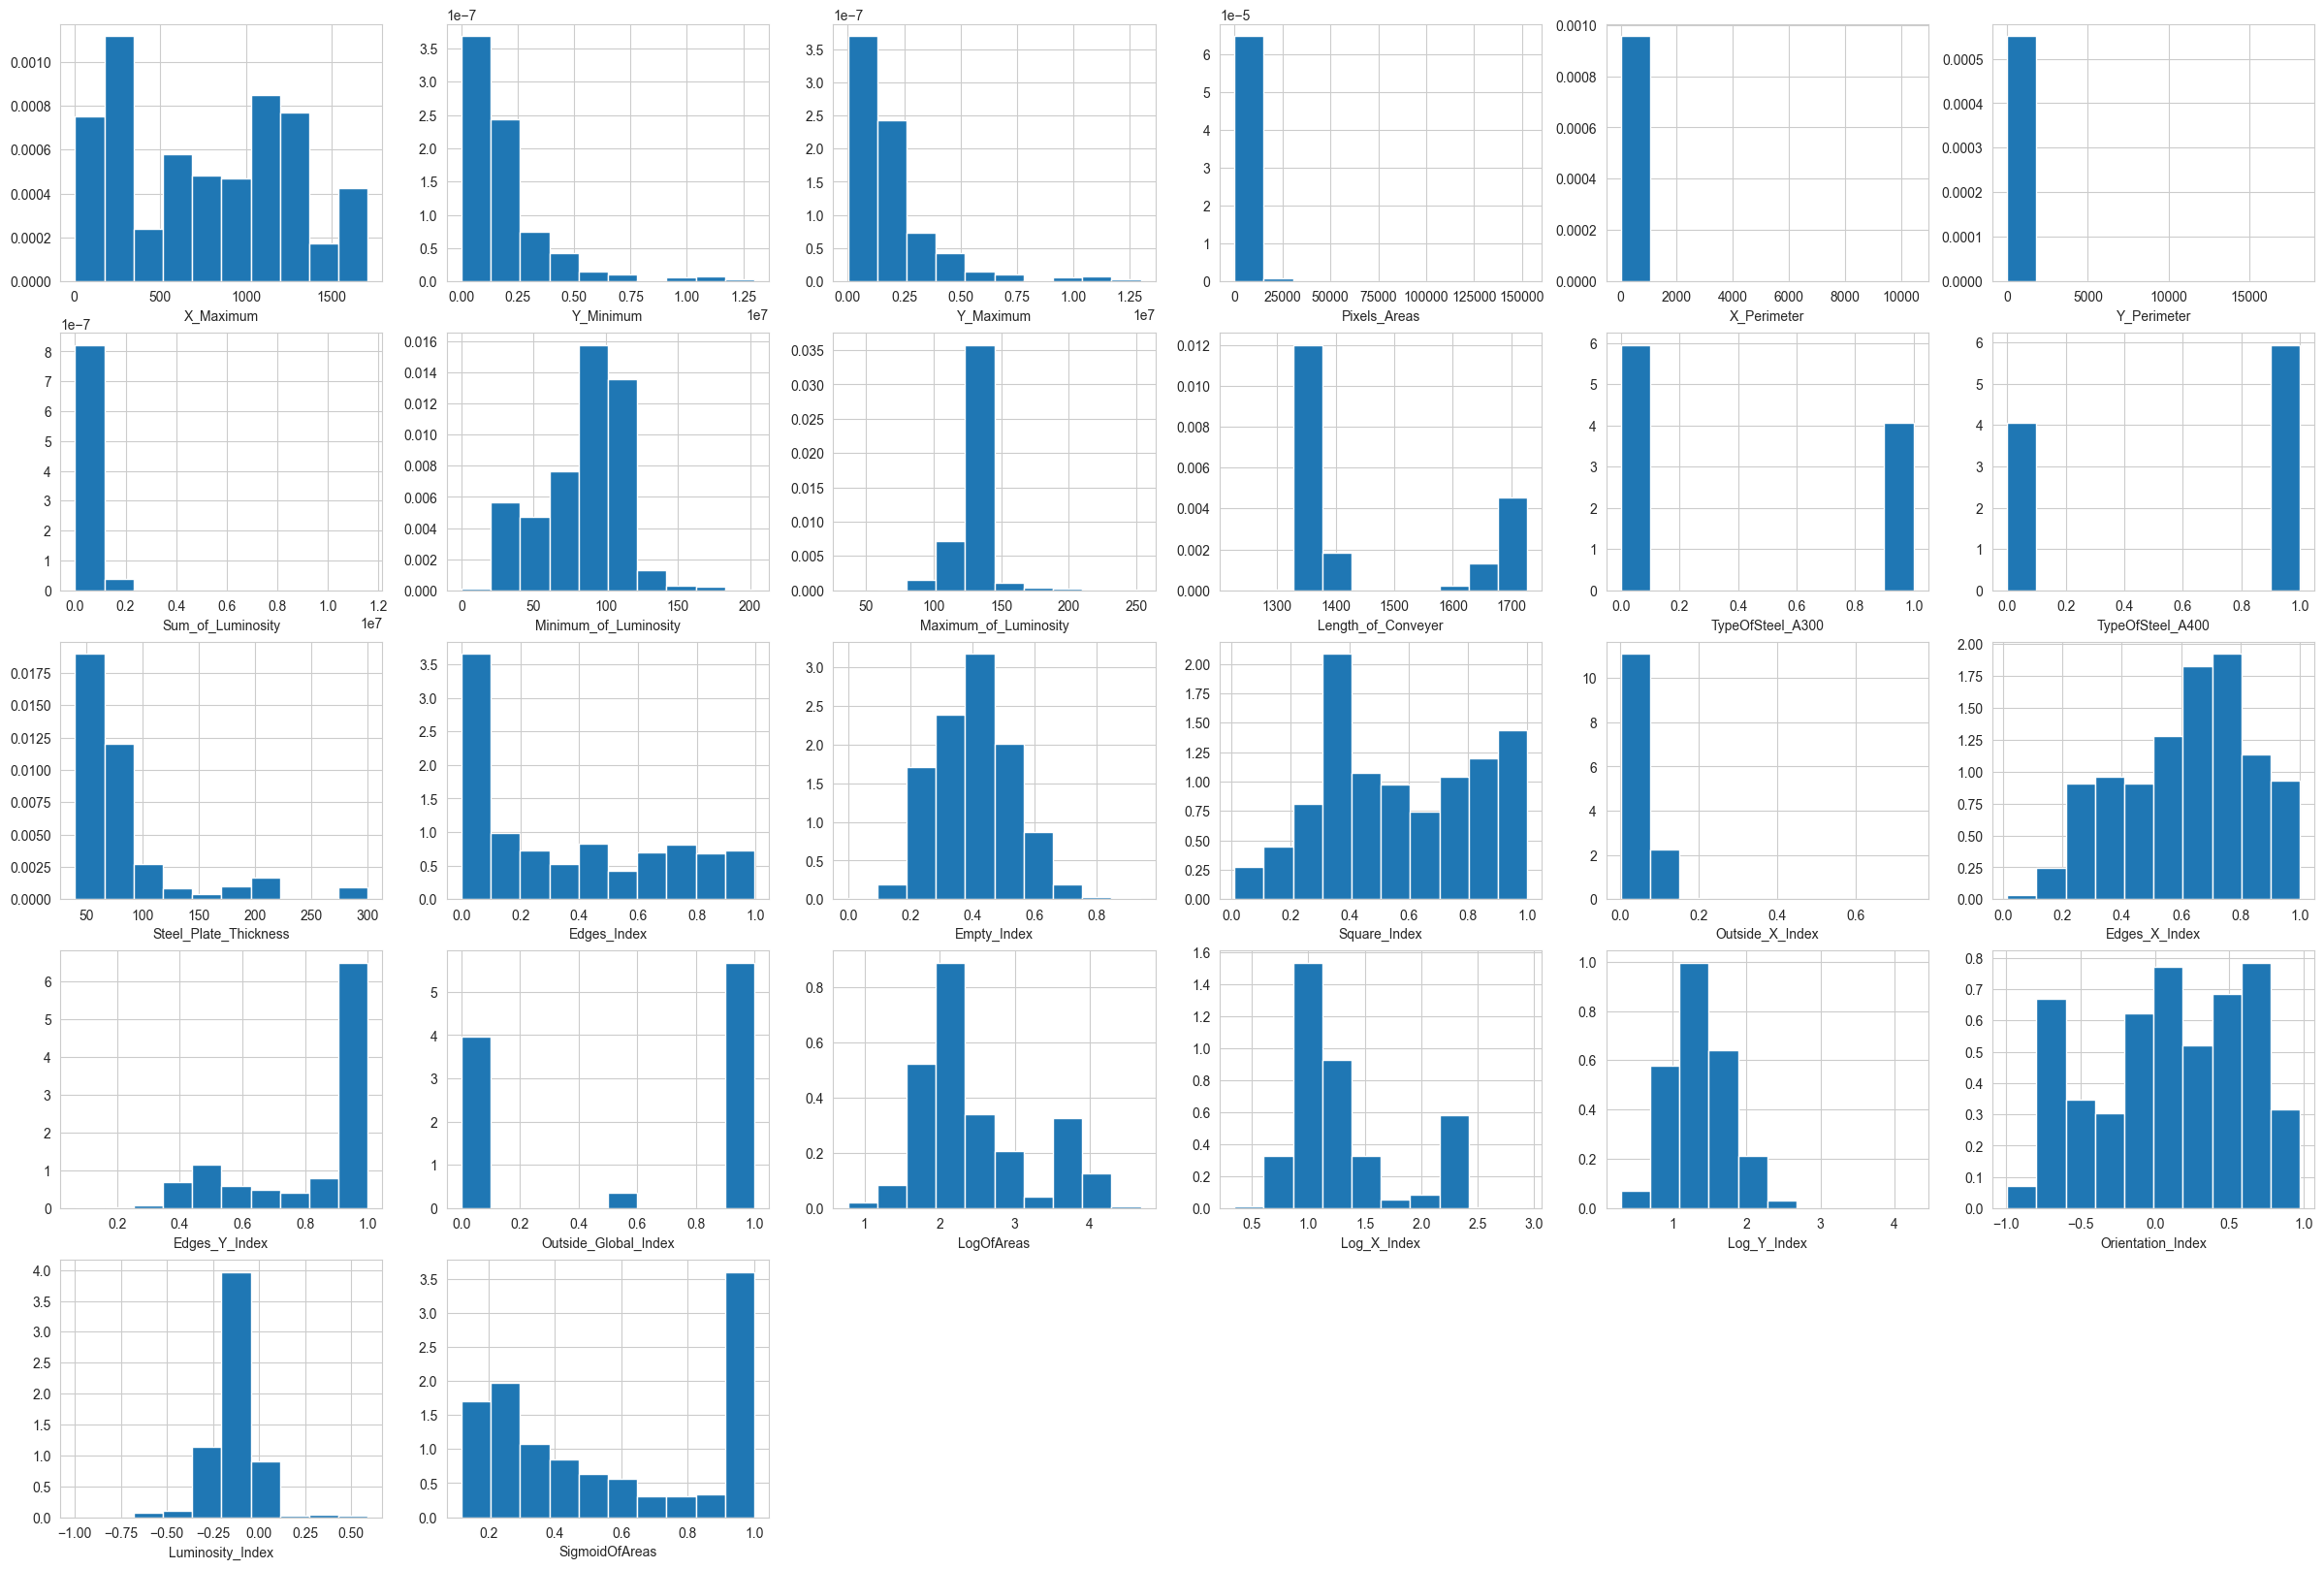

In [17]:
# Test Dataset
plt.figure(figsize=(30, 20))

for index, cols in enumerate(test.iloc[:, 1:].columns, start=1):
    plt.subplot(5, 6, index)
    plt.hist(test[cols], density=True)
    plt.xlabel(cols)
    
plt.show()

## Check outlier boxplot

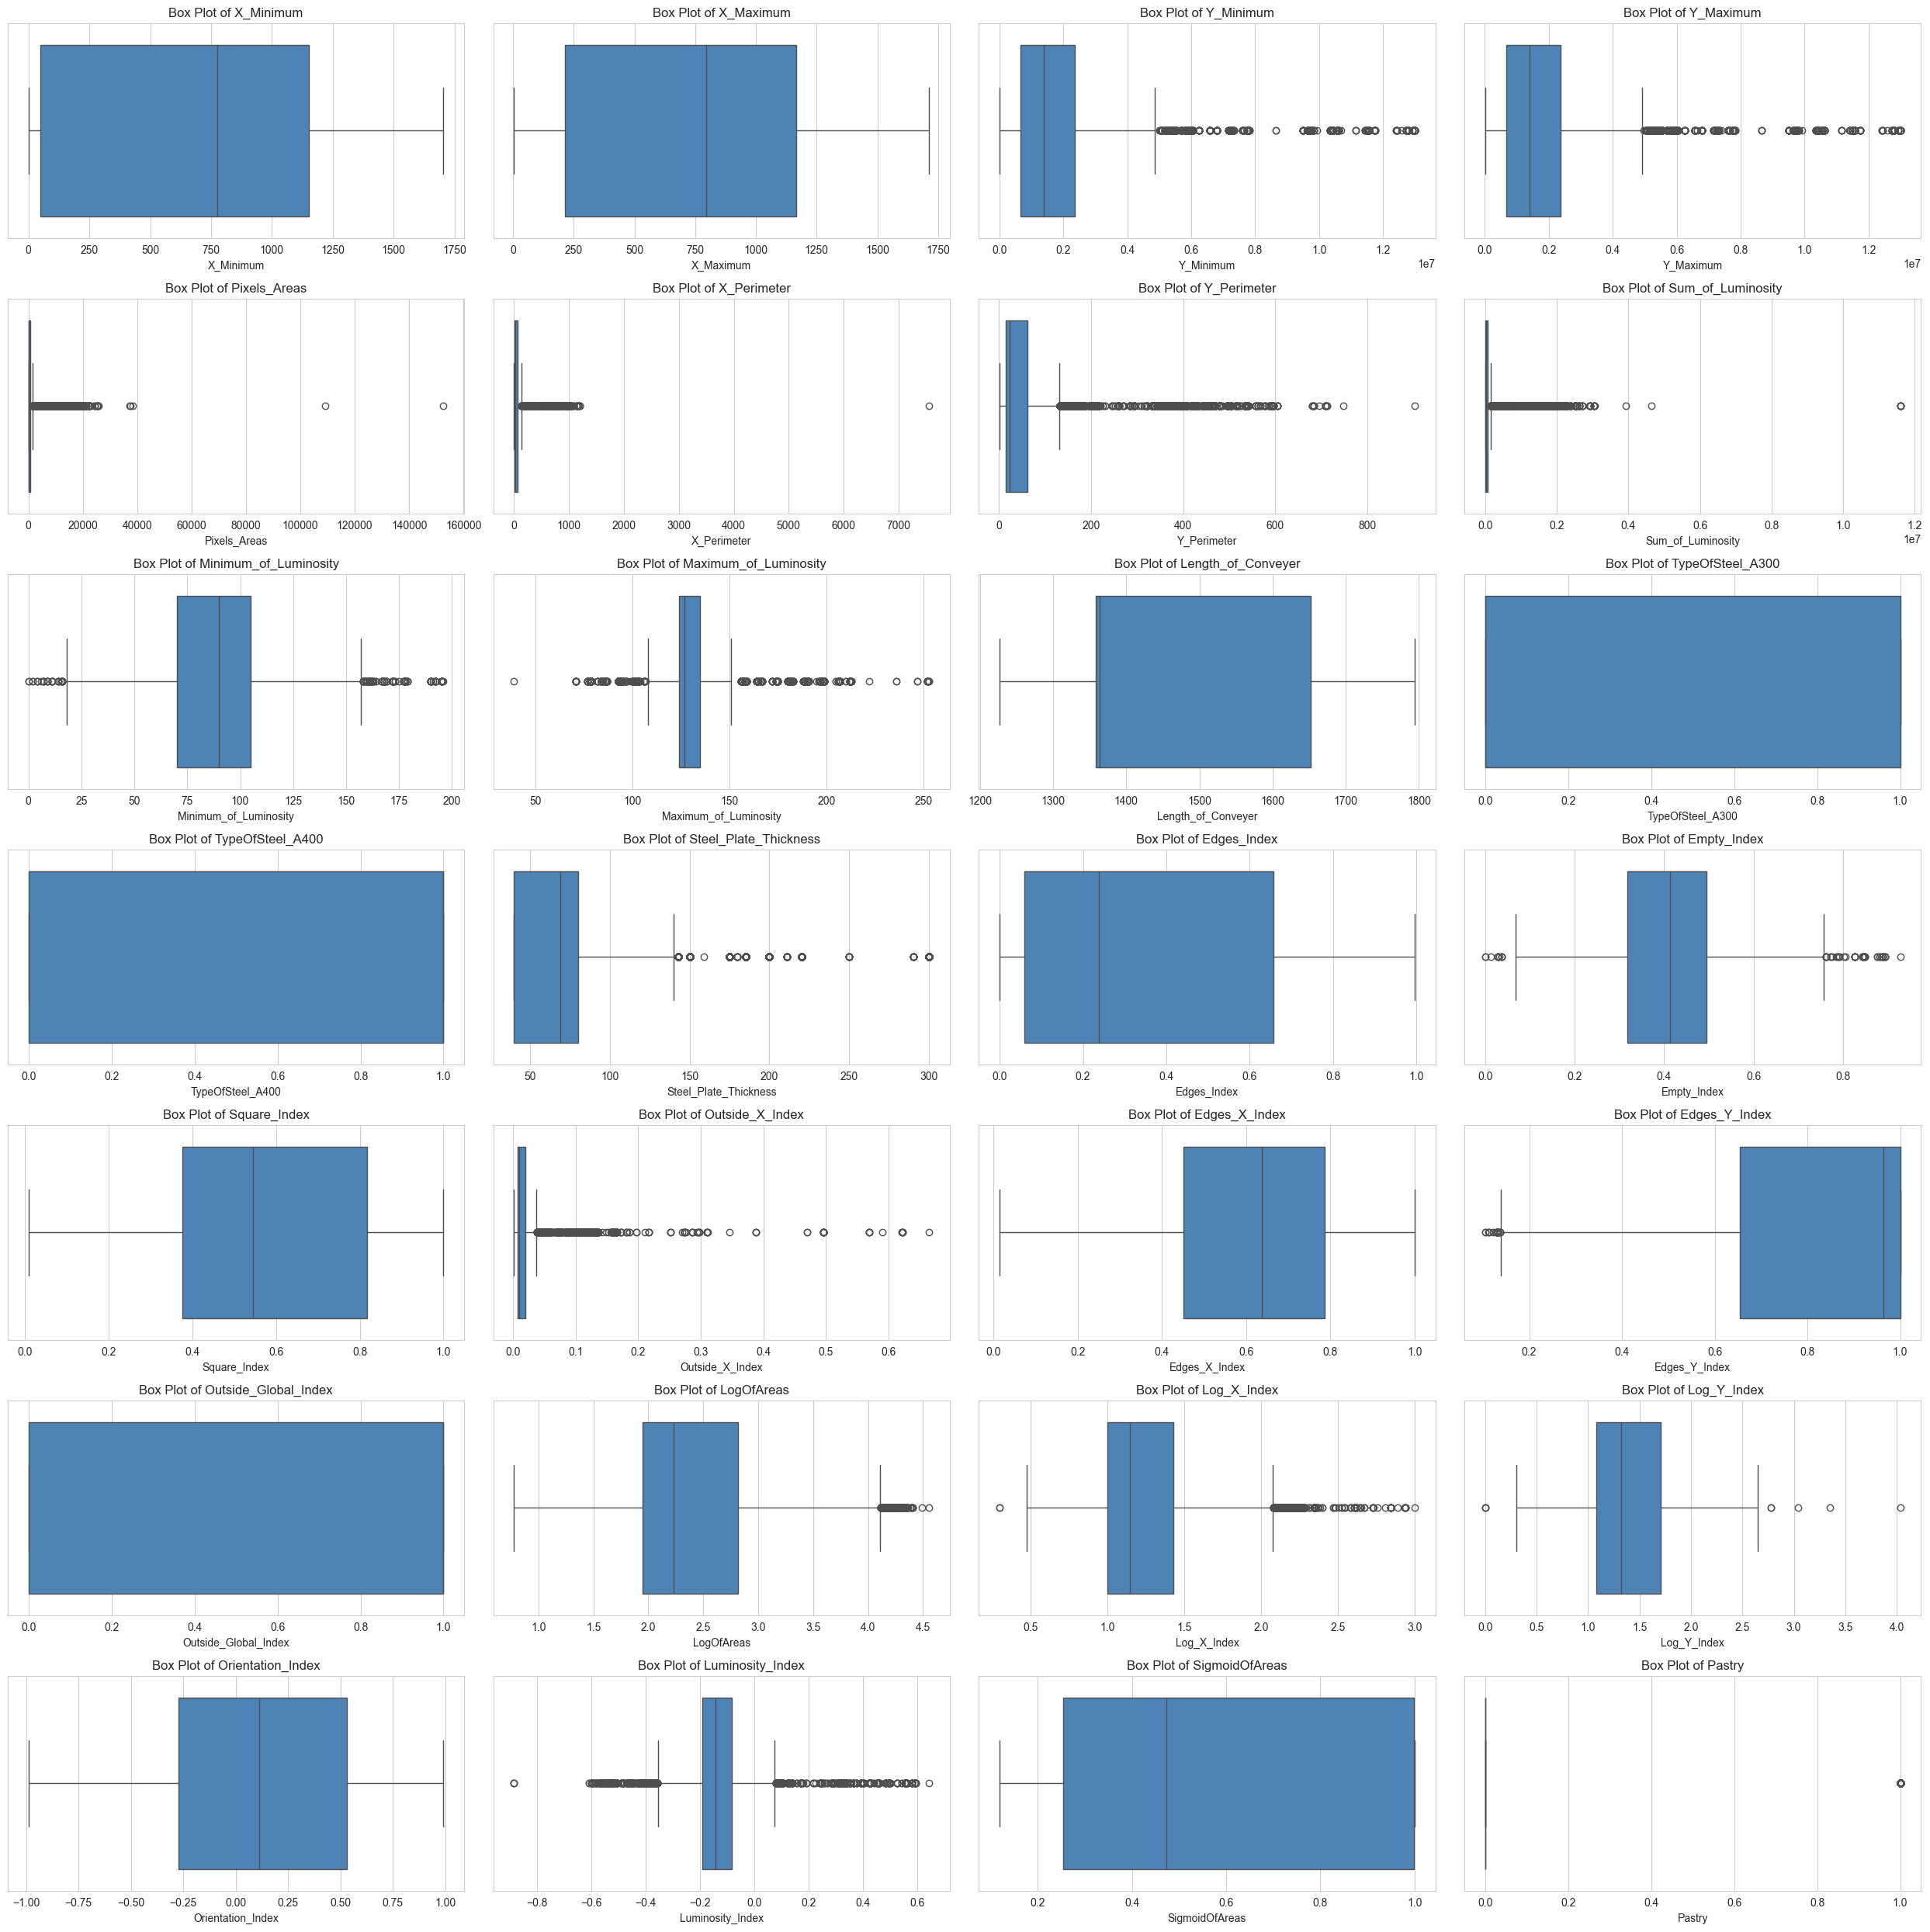

In [18]:
# Setting rows and columns numbers
num_rows = 7
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 25))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Iterate through features and add box plots to subplots
for i, column in enumerate(train.select_dtypes(include='number')):
    # Create box plot for the current feature
    if i < len(axes):
        sns.boxplot(x=train.select_dtypes(include='number')[column], ax=axes[i], color='#3d85c6')
        
        # Set title and labels
        axes[i].set_title(f'Box Plot of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('')

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()

# Data Preprocessing

In [19]:
# # removing outliers from the train dataset
# from sklearn.preprocessing import QuantileTransformer
# nqt = QuantileTransformer(output_distribution='normal')
# 
# for col in num_cols:
#    train[col] = nqt.fit_transform(train[[col]])

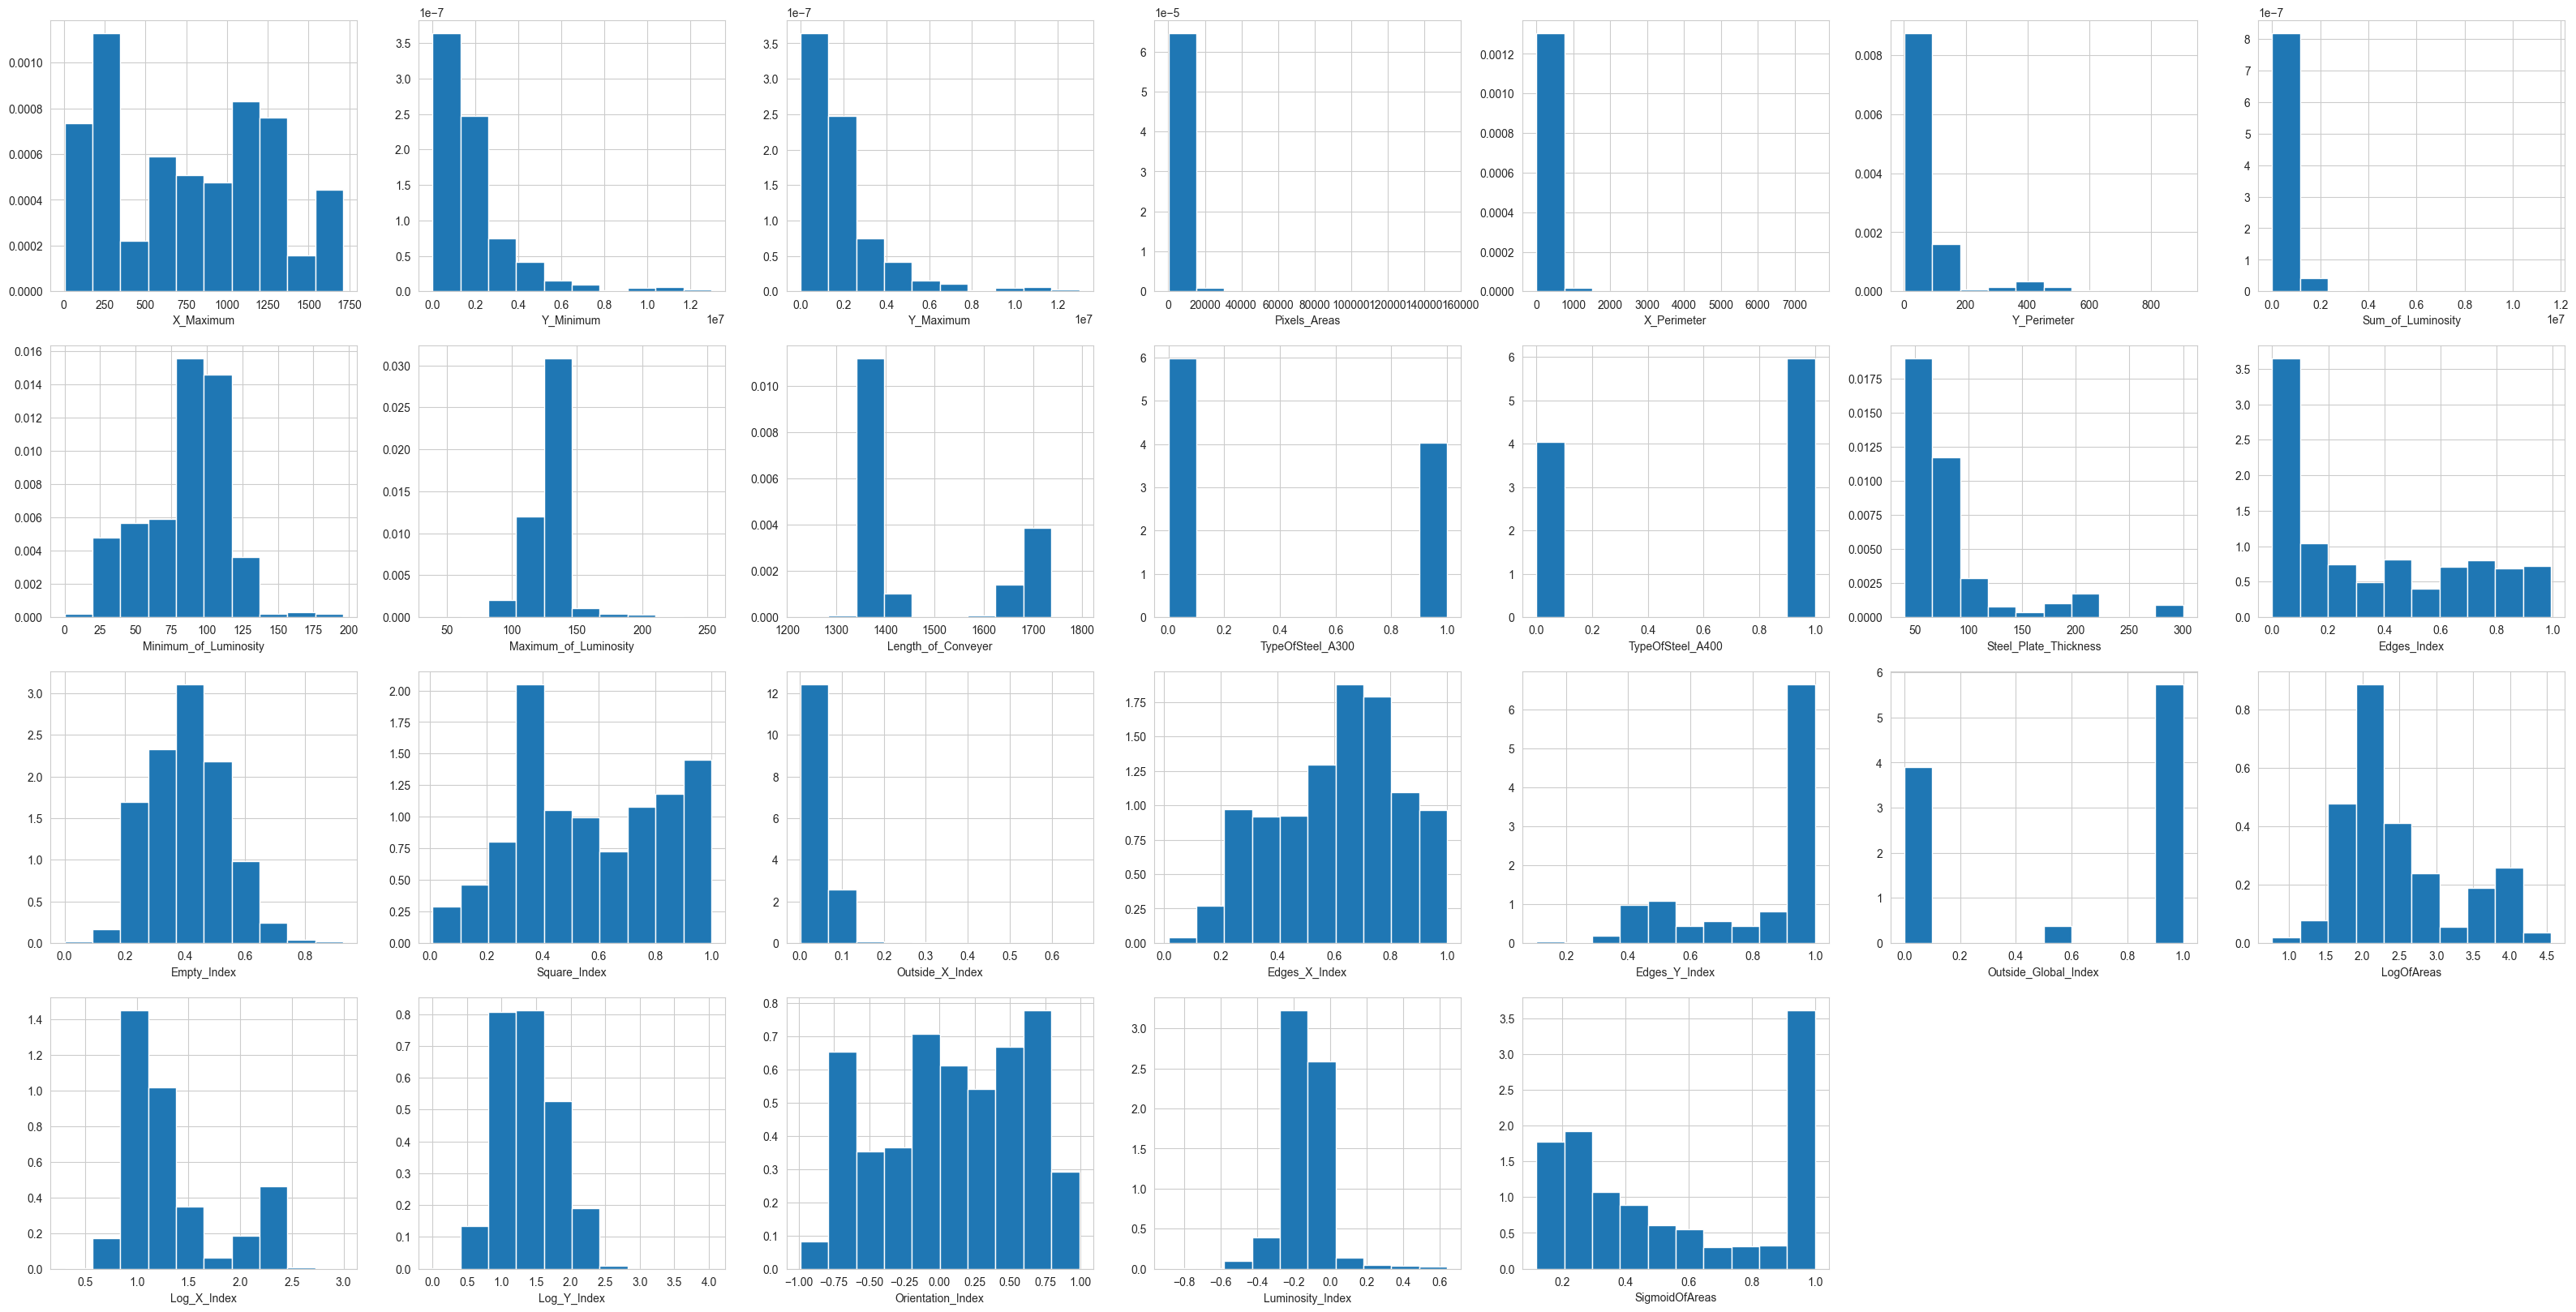

In [20]:
plt.figure(figsize=(40, 20))

for index, col in enumerate(train.iloc[:, 1:-7].columns, start=1):
   plt.subplot(4, 7, index)
   plt.hist(train[col], density=True)
   plt.xlabel(col)
    
plt.show()

# Feature Engineering

In [21]:
def feature_engineering(data):
    data['Ratio_Length_Thickness'] = data['Length_of_Conveyer'] / data['Steel_Plate_Thickness']
    data['Normalized_Steel_Thickness'] = (data['Steel_Plate_Thickness'] - data['Steel_Plate_Thickness'].min()) / (data['Steel_Plate_Thickness'].max() - data['Steel_Plate_Thickness'].min())
    data['X_Range*Pixels_Areas'] = (data['X_Maximum'] - data['X_Minimum']) * data['Pixels_Areas']
    return data

In [22]:
# train = feature_engineering(train)
# test = feature_engineering(test)

In [23]:
# features_to_drop = ['Y_Minimum', 'Steel_Plate_Thickness', 'Sum_of_Luminosity', 'Edges_X_Index', 'SigmoidOfAreas', 'Luminosity_Index', 'TypeOfSteel_A300']
# train = train.drop(features_to_drop,axis = 1)
# test = test.drop(features_to_drop,axis = 1)

# Modeling

In [24]:
X = train.drop(target_cols, axis=1)
y = train[target_cols]

# Train Test Split
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## XGBoost

In [ ]:
xgboost_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    #"max_depth": 12,
    "learning_rate": 0.005,
    "subsample": 0.85,
    "colsample_bytree": 0.85,
    "alpha": 0.001,
    "lambda": 0.001,
    "gamma": 0.1,
    "min_child_weight": 5,
    "n_estimators": 1500,
    "random_state": 42
}
submission[target_cols] = 0
# Initialize XGBoost classifier
xgboost_model = xgb.XGBClassifier(**xgboost_params)

# List to store AUC scores for each target variable
auc_scores = []

# Perform cross-validation for each target variable
for target in target_cols:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y[target], test_size=0.2, random_state=42)
    
    # Fit the model
    xgboost_model.fit(X_train, y_train)
    
    # Predict probabilities
    y_pred_proba = xgboost_model.predict_proba(X_test)[:, 1]
    
    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc_score)

    # Add predictions to submission DataFrame
    submission[target] += xgboost_model.predict_proba(test)[:, 1]

# Calculate mean AUC score
mean_auc_score = np.mean(auc_scores)

# Print mean AUC score
print("Mean AUC Score (XGBoost):", mean_auc_score)

## LGBM

In [27]:
# Функция для задачи Optuna
def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': 8,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'n_estimators': 3000,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 8),
        'device_type': 'cpu',
        'num_leaves': trial.suggest_int('num_leaves', 4, 2048),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "verbosity": -1,
        "early_stopping_rounds": 50,
    }

    auc_scores = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, valid_idx in kf.split(X):
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]

        model = LGBMClassifier(**param)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)], verbose=False, early_stopping_rounds=50)

        y_prob = model.predict_proba(X_valid_fold)
        average_auc = roc_auc_score(y_valid_fold, y_prob, multi_class="ovr", average="macro")
        auc_scores.append(average_auc)

    return np.mean(auc_scores)

In [28]:
# Запускаем Optuna для оптимизации гиперпараметров
RETRAIN_LGBM_MODEL = True
if RETRAIN_LGBM_MODEL:
    lgbm_study = optuna.create_study(direction='maximize', study_name="lgbm_model_training")
    lgbm_study.optimize(objective, n_trials=200)

    print(f"Best trial average AUC: {lgbm_study.best_value:.4f}")
    print(lgbm_study.best_params)

    best_params = lgbm_study.best_params

else:
    best_params = {
        'objective': 'multiclass',
        'num_class': 8,
        'learning_rate': 0.00711725041768046,
        'n_estimators': 3000,
        'lambda_l1': 0.00440985033109004,
        'lambda_l2': 1.0606279361419868e-08,
        'max_depth': 8,
        'colsample_bytree': 0.33443191322905963,
        'subsample': 0.6551114943335209,
        'min_child_weight': 1,
        'num_leaves': 1019,
        'min_child_samples': 94,
        "verbosity": -1,
        "early_stopping_rounds": 50,
    }

[I 2024-05-28 03:36:56,277] A new study created in memory with name: lgbm_model_training
[W 2024-05-28 03:36:56,283] Trial 0 failed with parameters: {'learning_rate': 0.04014825151044938, 'lambda_l1': 2.926166959109072e-06, 'lambda_l2': 0.00012257128001698432, 'max_depth': 15, 'colsample_bytree': 0.4698353988435433, 'subsample': 0.5698097227996329, 'min_child_weight': 4, 'num_leaves': 1164, 'min_child_samples': 64} because of the following error: TypeError("LGBMClassifier.fit() got an unexpected keyword argument 'verbose'").
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\user\AppData\Local\Temp\ipykernel_23564\724739604.py", line 29, in objective
    model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)], verbose=False, early_stopping_rounds=50)
TypeError: LGBMC

TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'verbose'

In [ ]:
# Обучение модели с наилучшими гиперпараметрами на всех данных и прогнозирование для тестового набора
best_params = trial.params
final_model = MultiOutputClassifier(LGBMClassifier(**best_params))
final_model.fit(X, y)

predictions = final_model.predict_proba(test)
predictions = np.array([pred[:, 1] for pred in predictions]).T

# Формирование файла для отправки
submission[target_cols] = predictions

In [ ]:
# Обучение модели с наилучшими параметрами
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

In [ ]:
# Предсказания и оценка модели
y_pred_proba = final_model.predict_proba(X_test)
mean_auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print("Mean AUC Score (LightGBM):", mean_auc_score)
submission[target_cols] = final_model.predict_proba(test)

# Submission file

In [ ]:
submission.to_csv('submissionLGBM.csv', index=False)

In [ ]:
submission.head()